In [1]:
import segyio
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

### Contracting Path
The contracting path is the encoder section of the U-Net which involves several downsampling steps.
It consists of the repeated application of two 3x3 convolutions (unpadded), each followed by a ReLU and 2x2 max pooling operation with stride of 2 for downsampling. At each downsampling step we double the number of feature channels

In [2]:
class ContractingBlock(nn.Module):
    '''
    ContractingBlock Class
    Performs two convolutions followed by a max pool operation.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels):
        super(ContractingBlock, self).__init__()
        
        # Wou want to double the number of channels in the first convolution
        # and keep the same number of channels in the second.
        
        self.conv1 = nn.Conv2d(input_channels, 2*input_channels, kernel_size=3, padding=(1,1))
        self.conv2 = nn.Conv2d(2*input_channels, 2*input_channels, kernel_size=3, padding=(1,1))
        self.activation = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
       

    def forward(self, x):
        '''
        Function for completing a forward pass of ContractingBlock: 
        Given an image tensor, completes a contracting block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x

In [5]:
# unit test
def test_contracting_block(test_samples = 1, test_channels=1, test_size=254):
    test_block = ContractingBlock(test_channels)
    test_in = torch.randn(test_samples, test_channels, test_size, test_size)
    test_out_conv1 = test_block.conv1(test_in)
    
    # Make sure that the first convolution has the right shape
    print(test_out_conv1.shape)
#     print(test_block.shape)

In [6]:
test_contracting_block(128)
# 1, 512, 60, 60

torch.Size([128, 2, 254, 254])


### Expanding Path
This is the decodign section of U-Net which has several upsampling steps. In order to do this, we will also need to write a crop function so that we can crop the image from contracting path and concatenate it to the current image on the expanding path - this is to form a skip connection.

Every step in expanding path consists of an upsampling of the feature map followed by a 2x2 convolution("up-convolution") that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from contracting path and two 3x3 convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels in every convolution.
(Later models basded on U-Net often use padding in the convolutions to prevent the size of the image from changing outside of the upsampling /downsampling steps)

In [6]:
# # this is useful when output size is smaller than the input as in the original UNet. 
# # But for now, we will not apply crop at the skip connection step.
# def crop(image, new_shape):
#     '''
#     Function for cropping an image tensor: Given an image tensor and the new shape,
#     crops to the center pixels.
#     Parameters:
#         image: image tensor of shape (batch size, channels, height, width)
#         new_shape: a torch.Size object with the shape you want x to have
#     '''
#     # There are many ways to implement this crop function, but it's what allows
#     # the skip connection to function as intended with two differently sized images!
    
#     h, w = image.shape[2], image.shape[3]
#     new_h, new_w = new_shape[2], new_shape[3]
    
#     start_h = int((h - new_h + 1)/2)
#     start_w = int((w - new_w + 1)/2)
    
#     cropped_image = image[:, :, start_h:start_h + new_h, start_w:start_w + new_w] 
    
#     return cropped_image

In [7]:
# # Unit test
# def test_crop(test_samples=100, test_channels=10, test_size=100):
#     # Make sure that the crop function is the right shape
#     skip_con_x = torch.randn(test_samples, test_channels, test_size + 6, test_size + 6)
#     x = torch.randn(test_samples, test_channels, test_size, test_size)
#     cropped = crop(skip_con_x, x.shape)
#     print(cropped.shape)

In [7]:
# test_crop()

In [3]:
class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock Class
    Performs an upsampling, a convolution, a concatenation of its two inputs,
    followed by two more convolutions.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels):
        super(ExpandingBlock, self).__init__()
        
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)      
        self.conv1 = nn.Conv2d(input_channels, input_channels//2, kernel_size=3, padding=(1,1))
        self.conv2 = nn.Conv2d(input_channels, input_channels//2, kernel_size=3, padding=(1,1))
        self.conv3 = nn.Conv2d(input_channels//2, input_channels//2, kernel_size=3, padding=(1,1))
        
        self.activation = nn.ReLU() # "each followed by a ReLU"
 
    def forward(self, x, skip_con_x):
        '''
        Function for completing a forward pass of ExpandingBlock: 
        Given an image tensor, completes an expanding block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
            skip_con_x: the image tensor from the contracting path (from the opposing block of x)
                    for the skip connection
                    
        Note: In the original Unet implementation, the output shape is smaller than the input, which 
        requires a skip connection layer size to be matched with current layer. 
        In this application, since our input and output are to be same size, we will note crop the 
        skip connection layer. However, there is a placehold commented, if needed in future. 
        
        '''
        x = self.upsample(x)
        x = self.conv1(x)        
        #skip_con_x = crop(skip_con_x, x.shape)   # placeholder for cropping skip connection
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        return x

In [9]:
#UNIT TEST
def test_expanding_block(test_samples=1, test_channels=64*16, test_size=32):
    test_block = ExpandingBlock(test_channels)
    skip_con_x = torch.randn(test_samples, test_channels // 2, test_size * 2 + 6, test_size * 2 + 6)
    x = torch.randn(test_samples, test_channels, test_size, test_size)
    x = test_block.upsample(x)
    #x = test_block.conv1(x)
    # Make sure that the first convolution produces the right shape
    print(x.shape)
#     assert tuple(x.shape) == (test_samples, test_channels // 2,  test_size * 2 - 1, test_size * 2 - 1)
#     orginal_x = crop(skip_con_x, x.shape)
#     x = torch.cat([x, orginal_x], axis=1)
#     x = test_block.conv2(x)
#     # Make sure that the second convolution produces the right shape
#     assert tuple(x.shape) == (test_samples, test_channels // 2,  test_size * 2 - 3, test_size * 2 - 3)
#     x = test_block.conv3(x)
#     # Make sure that the final convolution produces the right shape
#     assert tuple(x.shape) == (test_samples, test_channels // 2,  test_size * 2 - 5, test_size * 2 - 5)
#     x = test_block.activation(x)

test_expanding_block()
# print("Success!")

torch.Size([1, 1024, 64, 64])


In [11]:
1, 1024, 32, 32

(1, 1024, 32, 32)

### Final Layer
This layer takes in a tensor with arbitrarily many tensors and produces a tensor with the same number of pixels but with the correct number of the output channels. 
At the final layer, a 1x1 convolution is used to map each 64-component feature vectore to the desired number of classes. In total the network has 23 convolutional layers

In [4]:
class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class
    The final layer of a UNet - 
    maps each pixel to a pixel with the correct number of output dimensions
    using a 1x1 convolution.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)
        

    def forward(self, x):
        '''
        Function for completing a forward pass of FeatureMapBlock: 
        Given an image tensor, returns it mapped to the desired number of channels.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        return x

In [11]:
# UNIT TEST
# assert tuple(FeatureMapBlock(10, 60)(torch.randn(1, 10, 10, 10)).shape) == (1, 60, 10, 10)
# print("Success!")

# print(FeatureMapBlock(1, 64)(torch.randn(1, 1, 512, 512)).shape)

torch.Size([1, 64, 512, 512])


## U-Net

In [5]:
class UNet(nn.Module):
    '''
    UNet Class
    A series of 4 contracting blocks followed by 4 expanding blocks to 
    transform an input image into the corresponding paired image, with an upfeature
    layer at the start and a downfeature layer at the end
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(UNet, self).__init__()
        
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        self.contract3 = ContractingBlock(hidden_channels * 4)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.expand1 = ExpandingBlock(hidden_channels * 16)
        self.expand2 = ExpandingBlock(hidden_channels * 8)
        self.expand3 = ExpandingBlock(hidden_channels * 4)
        self.expand4 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        
    def forward(self, x):
        '''
        Function for completing a forward pass of UNet: 
        Given an image tensor, passes it through U-Net and returns the output.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        # Keep in mind that the expand function takes two inputs, 
        # both with the same number of channels. 
                
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)        
        x2 = self.contract2(x1)        
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        
        x5 = self.expand1(x4, x3)
        x6 = self.expand2(x5, x2)
        x7 = self.expand3(x6, x1)
        x8 = self.expand4(x7, x0)
        xn = self.downfeature(x8)
        
        # To check if shapes are in right order        
        #print('x:', x.shape)
        #print('x0:', x0.shape)
        #print('x1:', x1.shape)
        #print('x2:', x2.shape)
        #print('x3:', x3.shape)
        #print('x4:', x4.shape)
        #print('x5:', x5.shape)
        #print('x6:', x6.shape)
        #print('x7:', x7.shape)
        #print('x8:', x8.shape)
        #print('xn:', xn.shape)
        
        return xn

In [13]:
# unit test
test_unet = UNet(1,1)
# print(test_unet(torch.randn(1, 1, 256, 256)).shape)
print(test_unet(torch.randn(1, 1, 512, 512)).shape)

torch.Size([1, 1, 512, 512])


## Training

  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   input_dim: the number of channels of the input image
  *   label_dim: the number of channels of the output image
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   initial_shape: the size of the input image (in pixels)
  *   target_shape: the size of the output image (in pixels)
  *   device: the device type

This should take only a few minutes to train!

In [6]:
# First load datasets

filename_pp = "D:/Machine_Learning/Xeek.ai/Fault_detection/Equinor Synthetic model/issap20_Pp.sgy"
# filename_ai = "D:/Machine_Learning/Xeek.ai/Fault_detection/Equinor Synthetic model/issap20_AI.sgy"
filename_fault = "D:/Machine_Learning/Xeek.ai/Fault_detection/Equinor Synthetic model/issap20_Fault.sgy"

In [7]:
# Note: the the xline header info location is at segyio.su.cdpx [181]
def segy2numpy(filename: str) -> np.array:
    with segyio.open(filename, xline=181) as segyfile:
        return segyio.tools.cube(segyfile)

seismic = segy2numpy(filename_pp)
# ai = segy2numpy(filename_ai)
fault = segy2numpy(filename_fault)
f"Number of inlines: {seismic.shape[0]}, crosslines: {seismic.shape[1]}, samples: {seismic.shape[2]}"

'Number of inlines: 101, crosslines: 589, samples: 751'

In [8]:
def crop_input(image, new_shape):
    '''
    Function for cropping an image tensor: Given an image tensor and the new shape,
    crops to the center pixels. Our data is of shape (101, 589, 751). Sometimes the odd shape causes
    shape mismatches in the UNet. For quick test, we will use this function to create our dataset in
    the shape of 512x512 which is a multiple of 32. 
    (Note: Need to test with the original shape if it works fine, in earlier attempt, it didn't!!!)
    
    Parameters:
        image: image tensor of shape (batch size, channels, height, width)
        new_shape: a torch.Size object with the shape you want x to have
    '''
    
    h, w = image.shape[0], image.shape[1]
    new_h, new_w = new_shape[0], new_shape[1]
    
    start_h = int((h - new_h + 1)/2)
    start_w = int((w - new_w + 1)/2)
    
    cropped_image = image[start_h:start_h + new_h, start_w:start_w + new_w] 
    
    return cropped_image

In [9]:
'''
Earlier, I had problem feeding the data into the network in the current shape which is (101, 512, 512)
The Pytorch implementation requires: (m, n, h, w) shape where,
m = no. of samples (in this case, no. of inlines)
n = number of channel ( 1 for greyscale or single channel)
h, w = 512
By concatenating each inlines into the list, I am trying to pretend each item on the list is a 2D image.
After that, we unsqueeze in the position (0) to add a 1 dimension, i.e (1 x 512 x 512)
Finally, we will stack all the item in the list to get a desired shape of (101, 1, 512, 512)
'''
new_shape = (512, 512)
image_list = []
fault_list = []
for i in range(101):
    images = torch.from_numpy(seismic[i])
    image_list.append(crop_input(images, new_shape ).unsqueeze(0))
    
    faults = torch.from_numpy(fault[i])
    fault_list.append(crop_input(faults, new_shape).unsqueeze(0))

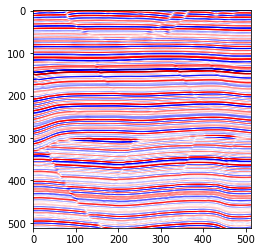

In [10]:
plt.imshow(image_list[0].T, cmap="seismic");

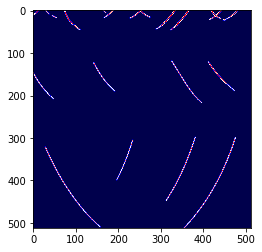

In [11]:
plt.imshow(fault_list[0].T, cmap="seismic");

In [ ]:
# Function to make the input data even multiple of 32

# import torch.nn.functional as F

# def pad_to(image, new_shape):
#     h, w = image.shape[0], image.shape[1]
#     new_h, new_w = new_shape[0], new_shape[1]
    
#     inc_h, inc_w = new_h -h, new_w - w
#     left, right = 0, inc_w
#     top, bottom = 0, inc_h
#     pads = left, right, top, bottom 
    

    
# # For general, need to revisit
# #     if h % stride > 0:
# #         new_h = h + stride - h % stride
# #     else:
# #         new_h = h
# #     if w % stride > 0:
# #         new_w = w + stride - w % stride
# #     else:
# #         new_w = w
# #     lh, uh = int((new_h-h) / 2), int(new_h-h) - int((new_h-h) / 2)
# #     lw, uw = int((new_w-w) / 2), int(new_w-w) - int((new_w-w) / 2)
# #     pads = (lw, uw, lh, uh)


#     # zero-padding by default.
#     # See others at https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.pad
#     out = F.pad(image, pads, "constant", 0)

#     return out

In [ ]:
# new_shape = (608, 768)
# image_list = []
# fault_list = []
# for i in range(101):
#     images = torch.from_numpy(seismic[i])
#     image_list.append(pad_to(images, new_shape).unsqueeze(0))
    
#     faults = torch.from_numpy(fault[i])
#     fault_list.append(pad_to(faults, new_shape).unsqueeze(0))

In [12]:
volumes = torch.stack(image_list)
labels = torch.stack(fault_list)
dataset = torch.utils.data.TensorDataset(volumes, labels)

In [13]:
volumes.shape, labels.shape

(torch.Size([101, 1, 512, 512]), torch.Size([101, 1, 512, 512]))

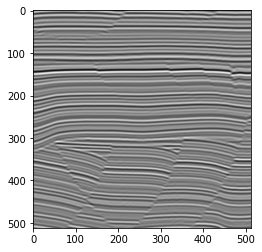

In [14]:
plt.imshow(volumes[100].T, cmap="gray");

In [15]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    # image_shifted = (image_tensor + 1) / 2
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.show()

In [16]:
# show_tensor_images(volumes[0])

In [17]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


In [21]:
# Hyperparameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 20    #200
input_dim = 1
label_dim = 1
display_step = 500
batch_size = 1
lr = 0.0002
initial_shape = 512
target_shape = 512
device = 'cuda'

In [19]:
def train():
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True)
    unet = UNet(input_dim, label_dim).to(device)
    unet_opt = torch.optim.Adam(unet.parameters(), lr=lr)
    cur_step = 0
    
    train_losses = []

    for epoch in range(n_epochs):
                
        for real, labels in tqdm(dataloader):
            
            cur_batch_size = len(real)
            # Flatten the image
            real = real.to(device)
            labels = labels.to(device)            
                      

            ### Update U-Net ###
            unet_opt.zero_grad()
            pred = unet(real)
            #print(pred.shape)
            unet_loss = criterion(pred, labels)
            unet_loss.backward()
            unet_opt.step()
            

            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: U-Net loss: {unet_loss.item()}")
                #show_tensor_images(
                    #crop(real, torch.Size([len(real), 1, target_shape, target_shape])), 
                    #size=(input_dim, target_shape, target_shape)
                #)
                show_tensor_images(real, size=(input_dim, target_shape, target_shape))
                show_tensor_images(labels, size=(label_dim, target_shape, target_shape))
                show_tensor_images(torch.sigmoid(pred), size=(label_dim, target_shape, target_shape))
            cur_step += 1
        
        train_losses.append(unet_loss)
        
    return pred, train_losses

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 0: Step 0: U-Net loss: 0.6958027482032776


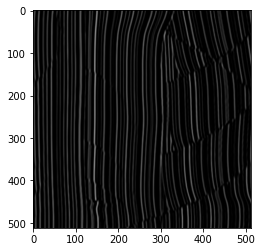

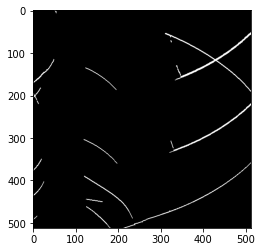

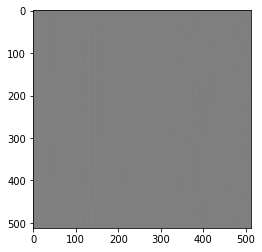

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 4: Step 500: U-Net loss: 0.09314978122711182


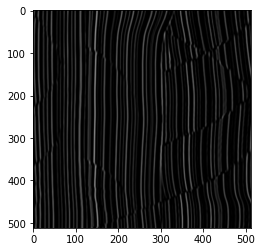

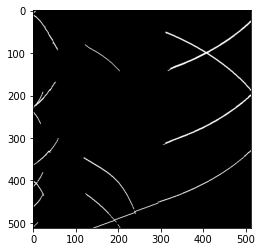

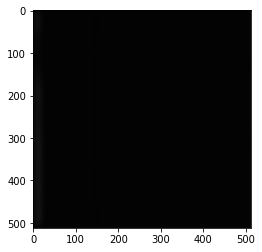

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 9: Step 1000: U-Net loss: 0.02101772278547287


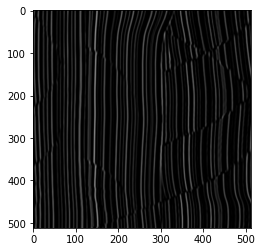

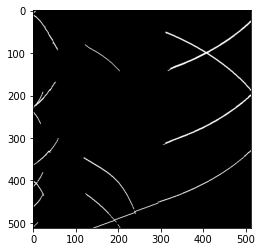

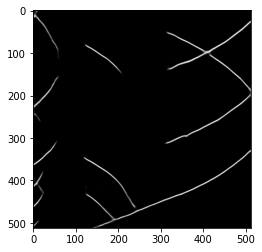

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 14: Step 1500: U-Net loss: 0.013765105977654457


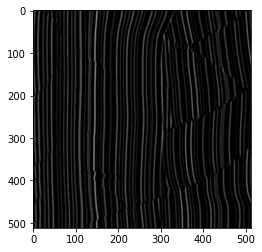

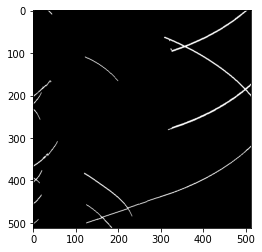

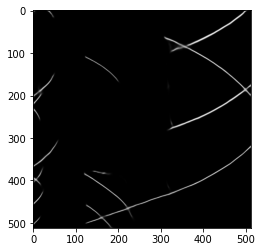

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 19: Step 2000: U-Net loss: 0.010353580117225647


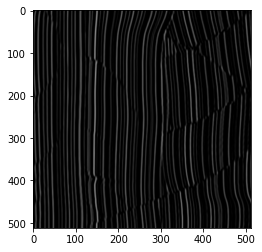

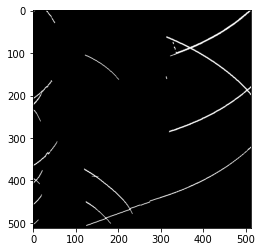

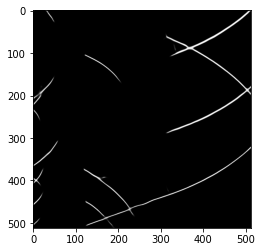

In [22]:
pred, loss = train()

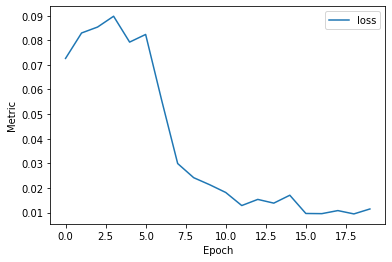

In [23]:
plt.plot(loss, label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.show()

In [24]:
# # Save weights
# torch.save(unet.cpu().state_dict(), model_path)
# unet.eval()